In [2]:
import sys; sys.version

'3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]'

LOADING DATA FROM KAGGLE

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

Dataset URL: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
License(s): CC0-1.0
 90% 89.0M/98.7M [00:01<00:00, 81.8MB/s]
100% 98.7M/98.7M [00:01<00:00, 81.6MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/melanoma-skin-cancer-dataset-of-10000-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import tensorflow as tf, numpy as np, pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [7]:
train_path = '/content/melanoma_cancer_dataset/train'
ds = keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size = (256, 256),
    shuffle =True,
)

Found 9605 files belonging to 2 classes.


In [8]:
test_path = '/content/melanoma_cancer_dataset/test'
test= keras.utils.image_dataset_from_directory(
    directory = test_path,
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size= (256, 256),
    shuffle = True,
)

Found 1000 files belonging to 2 classes.


DATASET SPLITTING

In [9]:
DATASET_SIZE= len(ds)
TRAIN_RATIO, VALIDATION_RATIO = 0.8, 0.2
train = ds.take(int(DATASET_SIZE*TRAIN_RATIO))
val  = ds.skip(int(DATASET_SIZE*TRAIN_RATIO))

print(len(train), len(val))

240 61


DATASET VISUALIZATION

In [10]:
import matplotlib.pyplot as plt

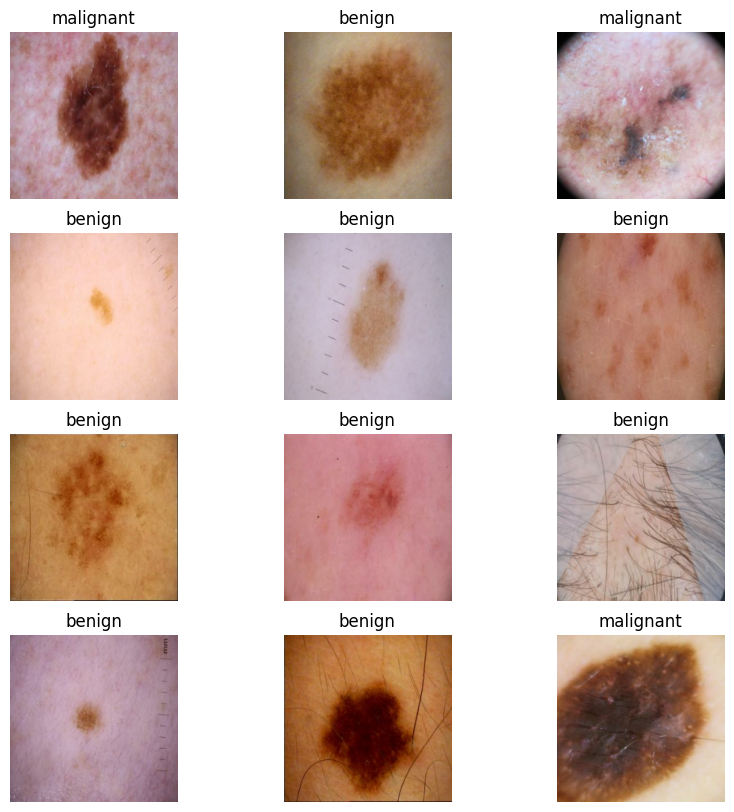

In [11]:
class_names = ds.class_names
plt.figure(figsize= (10,10))
for image_batch, label_batch in ds.take(1):
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]]); plt.axis('off')

MODEL BUILDING

In [12]:
from keras.layers import RandomFlip, RandomRotation

In [13]:
Augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

In [14]:
def Normalizer(image, label):
    image= tf.cast(image/255., tf.float32)
    return image, label
train, val, test = train.map(Normalizer), val.map(Normalizer), test.map(Normalizer)

In [15]:
model = Sequential([
    Augmentation,
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(units=64, activation="relu"),
    Dense(units=2, activation="softmax"),
])

model.build (input_shape=(None, 256, 256, 3))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,522 (216.88 KB)

 Trainable params: 55,522 (216.88 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(
    optimizer= 'adam',
    loss=  'sparse_categorical_crossentropy',
    metrics = ['accuracy',]
)

In [17]:
from keras.callbacks import EarlyStopping

In [18]:
early_stopping = EarlyStopping(
    monitor = 'accuracy',
    patience = 3,
    restore_best_weights = True,
)

MODEL TRAINING

In [ ]:
history = model.fit(train, batch_size= 32, epochs=25, verbose=1, validation_data=val, callbacks=[early_stopping])

Epoch 1/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.6503 - loss: 0.6114 - val_accuracy: 0.8499 - val_loss: 0.3385
Epoch 2/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - accuracy: 0.8532 - loss: 0.3387 - val_accuracy: 0.8462 - val_loss: 0.3266
Epoch 3/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.8633 - loss: 0.3238 - val_accuracy: 0.8753 - val_loss: 0.2900
Epoch 4/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.8612 - loss: 0.3279 - val_accuracy: 0.8769 - val_loss: 0.2863
Epoch 5/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.8768 - loss: 0.3007 - val_accuracy: 0.8764 - val_loss: 0.2786
Epoch 6/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 39s 87ms/step - accuracy: 0.8766 - loss: 0.2952 - val_accuracy: 0.8883 - val_loss: 0.2745
Epoch 7/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 33s 140ms/step - accuracy: 0.8840 - loss: 0.2899 - val_accuracy: 0.8821 - val_loss: 0.2808
Epoch 8/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step - accuracy: 0.8815 - loss: 0.2868 -

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'])

MODEL EVALUATION

In [ ]:
loss, accuracy = model.evaluate(test); print(loss, accuracy)

Actual Label:  malignant
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Label:  malignant


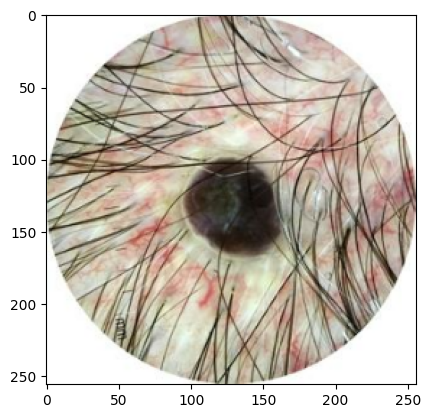

In [23]:
for images, label in test.take(1):
  img = (images[0]*255).numpy().astype('uint8')
  plt.imshow(img)
  print('Actual Label: ', class_names[label[0].numpy()])
  pred = model.predict(images)
  print('Predicted Label: ', class_names[np.argmax(pred[0])])

In [24]:
model.save('model.h5')

TypeError: cannot pickle 'module' object

In [25]:
model.save('model')

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=model.

In [29]:
model.save('model.keras')

CONFUSION MATRIX & PERFORMANCE EVALUATION

In [27]:
true, predicted = [], []
for images, labels in test:
    for img, label in zip(images, labels):
        true.append(label.numpy())
        pred = model.predict(tf.expand_dims(img, axis=0))
        predicted.append(np.argmax(pred[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

<Axes: >

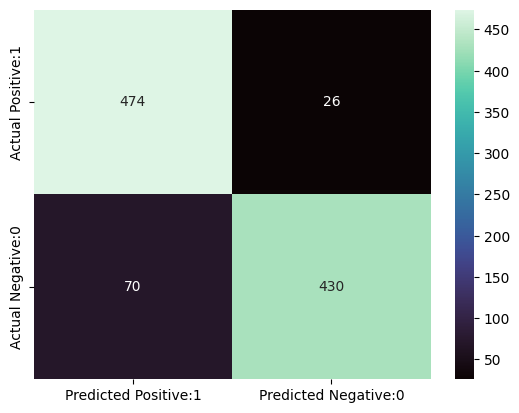

In [28]:
cm = confusion_matrix(true, predicted)
cm_matrix = pd.DataFrame(data=cm, columns=['Predicted Positive:1', 'Predicted Negative:0'], index=['Actual Positive:1', 'Actual Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt = 'd', cmap='mako')